# CSE 202:  *Power Grid* Experiments
## Winter 2025
### Melina Dimitropoulou Kapsogeorgou, Andrew Pan, Adrian Rosing, Andrew Russell, Benjamin Xia

In [2]:
import itertools
import networkx as nx
from networkx.algorithms import tree

## Pre-Game Initialization

In [3]:
def phase0_solve_kmst(G, K):
    V = list(G.nodes)
    E = list(G.edges)

    result_mst = None
    min_weight = float('inf')
    for Vp in itertools.combinations(V, K):
        subgraph = G.subgraph(Vp)
        if not nx.is_connected(subgraph):
            continue
        T = nx.minimum_spanning_tree(subgraph, algorithm='prim')
        total_cost = T.size(weight='weight')
        if total_cost < min_weight:
            result_mst = T
            min_weight = total_cost
    return (result_mst, min_weight)

In [4]:
G = nx.Graph([
    ('Seattle', 'Portland', { 'weight': 3 }),
    ('Seattle', 'Boise', { 'weight': 12 }),
    ('Seattle', 'Billings', { 'weight': 9 }),
    ('Portland', 'San Francisco', { 'weight': 24 }),
    ('Portland', 'Boise', { 'weight': 13 }),
    ('San Francisco', 'Los Angeles', { 'weight': 9 }),
    ('San Francisco', 'Las Vegas', { 'weight': 14 }),
    ('San Francisco', 'Salt Lake City', { 'weight': 27 }),
    ('San Francisco', 'Boise', { 'weight': 23 }),
    ('Boise', 'Billings', { 'weight': 12 }),
    ('Boise', 'Cheyenne', { 'weight': 24 }),
    ('Boise', 'Salt Lake City', { 'weight': 8 }),
    ('Las Vegas', 'Salt Lake City', { 'weight': 18 }),
    ('Las Vegas', 'Los Angeles', { 'weight': 9 }),
    ('Las Vegas', 'San Diego', { 'weight': 9 }),
    ('Las Vegas', 'Phoenix', { 'weight': 15 }),
    ('Las Vegas', 'Santa Fe', { 'weight': 27 }),
    ('Los Angeles', 'San Diego', { 'weight': 3 }),
    ('San Diego', 'Phoenix', { 'weight': 14 })
    # Etc.
])

Gp, min_weight = phase0_solve_kmst(G, 10)
nx.write_network_text(Gp)

╙── Phoenix
    └── San Diego
        └── Los Angeles
            ├── Las Vegas
            │   └── Salt Lake City
            │       └── Boise
            │           └── Seattle
            │               ├── Portland
            │               └── Billings
            └── San Francisco


## *Purchase Power Plants* Phase

In [5]:
def argmin(a):
    return min(range(len(a)), key=lambda x : a[x])
def argmax(a):
    return max(range(len(a)), key=lambda x : a[x])

def max_pow(P, f, ResourceCost, K):
    dp = []
    Pp = []
    for i in range(len(P) + 1):
        dp.append([0 for j in range(f + 1)])
        Pp.append([set() for j in range(f + 1)])
    for i in range(1, len(P) + 1):
        c, rt, ra, e = P[i - 1]
        running_cost = ra * ResourceCost[rt]
        for j in range(1, f + 1):
            no_change = dp[i - 1][j]
            add_plant = dp[i - 1][max(0, j - running_cost)] + e
            if j - running_cost <= 0 or no_change > add_plant:
                dp[i][j] = dp[i - 1][j]
                Pp[i][j] = Pp[i - 1][j].copy()
            else:
                dp[i][j] = add_plant
                Pp[i][j] = Pp[i - 1][j - running_cost] | set(P[i - 1:i])
    if max(dp[len(P)]) < K:
        return (
            max(dp[len(P)]),
            argmax(dp[len(P)]),
            dp,
            Pp
        )
    return (
        min([ x for x in dp[len(P)] if x >= K ]),
        argmin([ x for x in dp[len(P)] if x >= K ]),
        dp,
        Pp
    )

def phase1_purchase_power_plants(P, f, P_player, P_max, ResourceCost, K):
    # No purchase decision
    m0, c0, _, _ = max_pow(P_player, f, ResourceCost, K)

    # Purchase decision, no eviction decision
    m1 = 0
    c1 = 0
    p1 = None
    for i, p in enumerate(P):
        c_i, rt, ra, e = p
        m, c, _, _ = max_pow(P_player + [p], f - c_i, ResourceCost, K) 
        c += c_i
        if m > m1 or (m == m1 and c < c1):
            m1 = m
            c1 = c
            p1 = p

    # Purchase decision, eviction decision
    m2 = 0
    c2 = 0
    p2 = None
    d2 = None
    if len(P_player) > 0:
        for i, p in enumerate(P):
            c_i, rt, ra, e = p
            for pp in itertools.combinations(P_player, len(P_player) - 1):
                m, c, _, _ = max_pow([*pp, p], f - c_i, ResourceCost, K)
                c += c_i
                if m > m2 or (m == m2 and c < c2):
                    m2 = m
                    c2 = c
                    p2 = p
                    e2 = list(set(P_player) - set(pp))[0]

    out_p = None
    out_d = None
    if m0 >= m1 and m0 >= m2: # Doing nothing is best
        return out_p, out_d
    
    if m1 > m2 or (m1 == m2 and c1 <= c2):
        out_p = p1
    elif m2 > m1 or (m1 == m2 and c2 < c1):
        out_p = p2
        out_d = d2
    return out_p, out_d

In [6]:
P = [
    (4, 'Coal', 2, 1),
    (8, 'Coal', 3, 2),
    (10, 'Coal', 10, 2),
    (15, 'Coal', 2, 3),
    (20, 'Coal', 3, 5),
    (25, 'Coal', 2, 5),
    (31, 'Coal', 3, 6),
    (36, 'Coal', 3, 7),
    (42, 'Coal', 2, 6),

    (3, 'Oil', 2, 1),
    (7, 'Oil', 3, 2),
    (9, 'Oil', 1, 1),
    (16, 'Oil', 2, 3),
    (26, 'Oil', 2, 5),
    (32, 'Oil', 3, 6),
    (35, 'Oil', 1, 5),
    (40, 'Oil', 2, 6),

    (6, 'Trash', 1, 1),
    (14, 'Trash', 2, 2),
    (19, 'Trash', 2, 3),
    (24, 'Trash', 2, 4),
    (30, 'Trash', 3, 6),
    (38, 'Trash', 3, 7),

    (11, 'Uranium', 1, 2),
    (17, 'Uranium', 1, 2),
    (23, 'Uranium', 1, 3),
    (28, 'Uranium', 1, 4),
    (34, 'Uranium', 1, 5),
    (39, 'Uranium', 1, 6)
]
f = 50
P_player = [
    (31, 'Coal', 3, 6),
    (36, 'Coal', 3, 7),
    (5, 'Uranium', 1, 1),
]
P_max = 3
ResourceCost = {
    'Coal': 1,
    'Oil': 2,
    'Trash': 5,
    'Uranium': 10
}
K = 10

phase1_purchase_power_plants(P, f, P_player, P_max, ResourceCost, K)

((36, 'Coal', 3, 7), None)

## *Purchasing Resources*/*Building Connections*/*Powering Plants* Phase 

In [7]:
def phase2_purchase_build_power(P, Gp, C, f, ResourceCost, K, B):
    Vp = list(Gp.nodes)
    mst = list(tree.minimum_spanning_edges(G, algorithm='prim'))

    Prefix = [0]
    for i in range(1, len(mst) + 1):
        Prefix.append(Prefix[i - 1] + mst[i - 1][2]['weight'])

    MP, MC, dp, Pp = max_pow(P, f, ResourceCost, K)

    i = argmax([
        min(dp[len(P)][f - Prefix[i]], len(C) + i)
            for i in range(1, len(Vp) - len(C) + 1)
    ])
    M = len(C) + i

    if M >= K:
        i_star = min(dp[len(P)][f - Prefix[i]], len(C) + i)
    else:
        j = 0
        i_star = argmax([
            max([f - Prefix[i] - j + B * min(dp[len(P)][j], len(C) + i)])
                for j in range(0, f - Prefix[i] + 1)
        ])
        
    e = mst[0:(i_star + 1)]
    P_new = list(Pp[len(P)][f] - set(P))
    Rt = [ rt for (_, rt, _, _) in P_new ]
    Q = [ ra for (_, _, ra, _) in P_new ]
    return (Rt, Q), e, P_new

In [8]:
C = ['San Francisco', 'Boise', 'Las Vegas']
B = 1

phase2_purchase_build_power(P_player, G, C, f, ResourceCost, K, B)

(([], []),
 [('Seattle', 'Portland', {'weight': 3}),
  ('Seattle', 'Billings', {'weight': 9}),
  ('Seattle', 'Boise', {'weight': 12}),
  ('Boise', 'Salt Lake City', {'weight': 8}),
  ('Salt Lake City', 'Las Vegas', {'weight': 18}),
  ('Las Vegas', 'Los Angeles', {'weight': 9}),
  ('Los Angeles', 'San Diego', {'weight': 3}),
  ('Los Angeles', 'San Francisco', {'weight': 9}),
  ('San Diego', 'Phoenix', {'weight': 14}),
  ('Boise', 'Cheyenne', {'weight': 24}),
  ('Las Vegas', 'Santa Fe', {'weight': 27})],
 [])

# Experimentation

Pre Game Initialization

In [9]:
#Scaling with size of graph
import time 
import math

connections = [
    ('Seattle', 'Boise', { 'weight': 12 }),
    ('Seattle', 'Billings', { 'weight': 9 }),
    ('Seattle', 'Portland', { 'weight': 3 }),
    ('Seattle', 'San Francisco', { 'weight': 18 }),
    ('Seattle', 'Salt Lake City', { 'weight': 22 }),
    ('Portland', 'San Francisco', { 'weight': 24 }),
    ('Portland', 'Boise', { 'weight': 13 }),
    ('Portland', 'Salt Lake City', { 'weight': 19 }),
    ('Portland', 'Las Vegas', { 'weight': 26 }),
    ('San Francisco', 'Los Angeles', { 'weight': 9 }),
    ('San Francisco', 'Las Vegas', { 'weight': 14 }),
    ('San Francisco', 'Salt Lake City', { 'weight': 27 }),
    ('San Francisco', 'Boise', { 'weight': 23 }),
    ('San Francisco', 'Phoenix', { 'weight': 20 }),
    ('San Francisco', 'Santa Fe', { 'weight': 30 }),
    ('Boise', 'Billings', { 'weight': 12 }),
    ('Boise', 'Cheyenne', { 'weight': 24 }),
    ('Boise', 'Salt Lake City', { 'weight': 8 }),
    ('Boise', 'Denver', { 'weight': 20 }),
    ('Boise', 'Santa Fe', { 'weight': 29 }),
    ('Billings', 'Cheyenne', { 'weight': 17 }),
    ('Billings', 'Denver', { 'weight': 20 }),
    ('Billings', 'Salt Lake City', { 'weight': 19 }),
    ('Billings', 'Santa Fe', { 'weight': 31 }),
    ('Cheyenne', 'Denver', { 'weight': 2 }),
    ('Cheyenne', 'Salt Lake City', { 'weight': 21 }),
    ('Cheyenne', 'Santa Fe', { 'weight': 19 }),
    ('Las Vegas', 'Salt Lake City', { 'weight': 18 }),
    ('Las Vegas', 'Los Angeles', { 'weight': 9 }),
    ('Las Vegas', 'San Diego', { 'weight': 9 }),
    ('Las Vegas', 'Phoenix', { 'weight': 15 }),
    ('Las Vegas', 'Santa Fe', { 'weight': 27 }),
    ('Las Vegas', 'Denver', { 'weight': 22 }),
    ('Los Angeles', 'San Diego', { 'weight': 3 }),
    ('Los Angeles', 'Phoenix', { 'weight': 13 }),
    ('Los Angeles', 'Santa Fe', { 'weight': 28 }),
    ('San Diego', 'Phoenix', { 'weight': 14 }),
    ('San Diego', 'El Paso', { 'weight': 24 }),
    ('Phoenix', 'Santa Fe', { 'weight': 22 }),
    ('Phoenix', 'Denver', { 'weight': 28 }),
    ('Phoenix', 'El Paso', { 'weight': 10 }),
    ('Santa Fe', 'Denver', { 'weight': 7 }),
    ('Santa Fe', 'El Paso', { 'weight': 13 }),
    ('Denver', 'Salt Lake City', { 'weight': 16 }),
    ('Denver', 'El Paso', { 'weight': 21 }),
    ('Denver', 'Kansas City', { 'weight': 24 }),
    ('El Paso', 'San Antonio', { 'weight': 15 }),
    ('El Paso', 'Dallas', { 'weight': 19 }),
    ('Kansas City', 'Dallas', { 'weight': 21 }),
    ('Dallas', 'San Antonio', { 'weight': 16 })
]

def num_con_exp():
    times = []
    for i in range(10, len(connections)):
        G = nx.Graph(connections[:i])
        start = time.time()
        Gp, min_weight = phase0_solve_kmst(G, 10)
        end = time.time()
        if not math.isinf(min_weight):
            times += [(i, end-start,min_weight)]
            # nx.write_network_text(Gp)
    return times


num_con_res = num_con_exp()



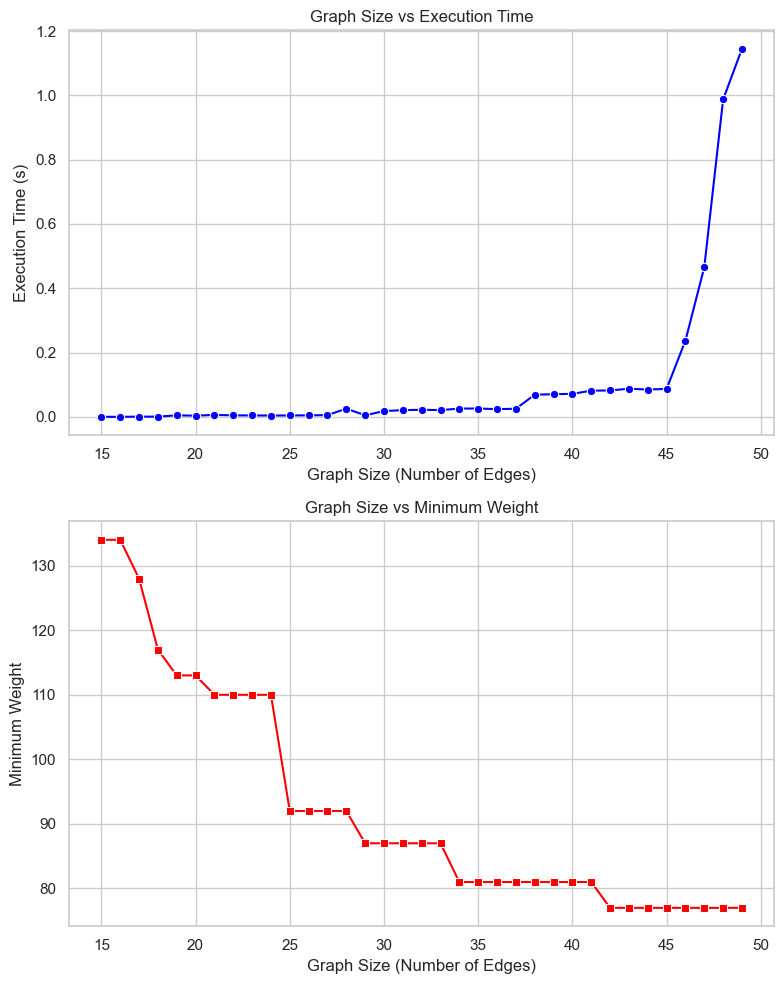

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

sizes = [x[0] for x in num_con_res]
times = [x[1] for x in num_con_res]
min_weights = [x[2] for x in num_con_res]

sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 1, figsize=(8, 10))  # Two rows, one column

# Execution Time
sns.lineplot(x=sizes, y=times, marker='o', color='blue', ax=axes[0])
axes[0].set_title("Graph Size vs Execution Time")
axes[0].set_xlabel("Graph Size (Number of Edges)")
axes[0].set_ylabel("Execution Time (s)")

#  Minimum Weight
sns.lineplot(x=sizes, y=min_weights, marker='s', color='red', ax=axes[1])
axes[1].set_title("Graph Size vs Minimum Weight")
axes[1].set_xlabel("Graph Size (Number of Edges)")
axes[1].set_ylabel("Minimum Weight")

plt.tight_layout()
plt.show()


In [11]:
# scaling with number of cities needed
def num_k_exp():
    times = []
    G = nx.Graph(connections)
    for i in range(1, len(connections)+1):
        start = time.time()
        Gp, min_weight = phase0_solve_kmst(G, i)
        end = time.time()
        if not math.isinf(min_weight):
            times += [(i, end-start,min_weight)]
            # nx.write_network_text(Gp)
    return times


num_k_res = num_k_exp()


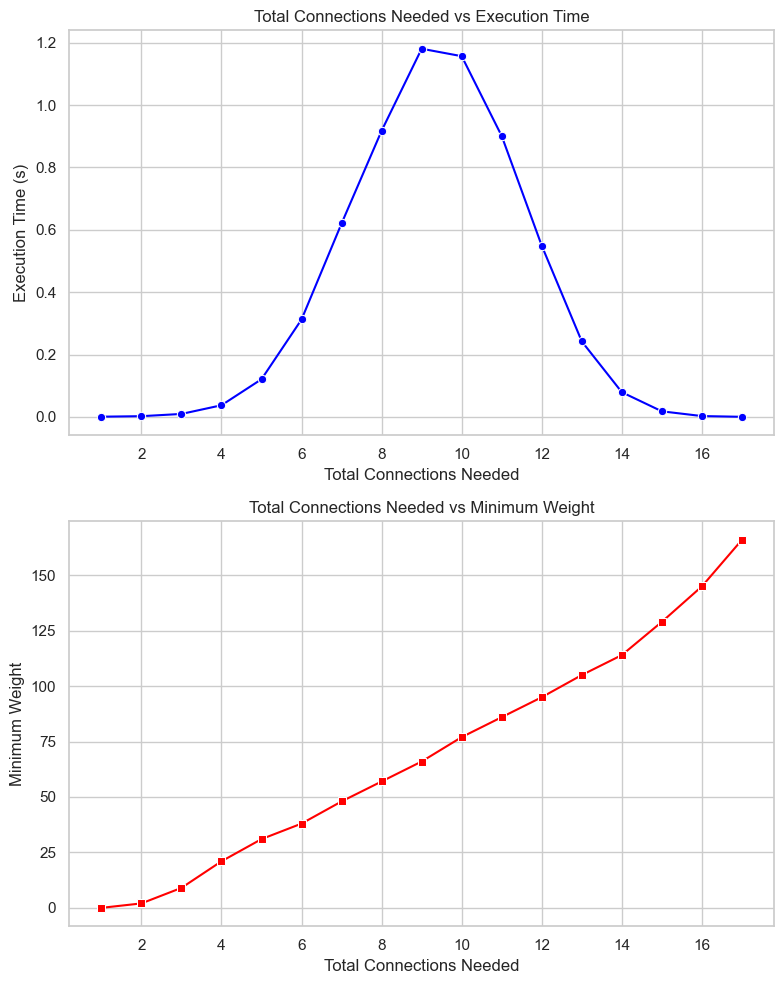

In [12]:

ks = [x[0] for x in num_k_res]
times = [x[1] for x in num_k_res]
min_weights = [x[2] for x in num_k_res]

sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 1, figsize=(8, 10))  # Two rows, one column

#  Execution Time
sns.lineplot(x=ks, y=times, marker='o', color='blue', ax=axes[0])
axes[0].set_title("Total Connections Needed vs Execution Time")
axes[0].set_xlabel("Total Connections Needed")
axes[0].set_ylabel("Execution Time (s)")

# Plot Minimum Weight
sns.lineplot(x=ks, y=min_weights, marker='s', color='red', ax=axes[1])
axes[1].set_title("Total Connections Needed vs Minimum Weight")
axes[1].set_xlabel("Total Connections Needed")
axes[1].set_ylabel("Minimum Weight")

# Layout adjustments
plt.tight_layout()
plt.show()